In [100]:
# DEBUG: Plot page element boxes
def draw_page_boxes(page_image, table_location=None, row_boxes=None, column_boxes=None):

	# Draw page
	fig, ax = plt.subplots()
	fig.set_size_inches(8.5, 11)
	COLORS = [[0.000, 0.447, 0.741], [0.850, 0.525, 0.398], [0.629, 0.194, 0.625], [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
	num_colors = len(COLORS)
	ax.axis('off')
	ax.imshow(page_image)

	# Draw table box
	if table_location:
		padding = 4
		(tl_xmin, tl_ymin, tl_xmax, tl_ymax) = table_location
		ax.add_patch(plt.Rectangle((tl_xmin - padding, tl_ymin - padding), tl_xmax - tl_xmin + padding * 2, tl_ymax - tl_ymin + padding * 2, fill=False, color=[1, 0, 0], linewidth=0.5))

	# Draw row boxes
	if row_boxes:
		for i, box in enumerate(row_boxes):
			(xmin, ymin, xmax, ymax) = box
			ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color=COLORS[0], linewidth=0.5))

	# Draw column boxes
	if column_boxes:
		for i, box in enumerate(column_boxes):
			(xmin, ymin, xmax, ymax) = box
			ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color=COLORS[i % len(COLORS)], linewidth=2))


In [129]:
#
# Processing functions
#
import base64
import cv2
import io
import matplotlib.pyplot as plt
import numpy as np
import pytesseract
import re
import torch

from gtts import gTTS
from io import BytesIO
from PIL import Image
from transformers import DetrFeatureExtractor, TableTransformerForObjectDetection

#
# Check if columns are closely adjacent
#
def are_columns_adjacent(box1, box2):
  return abs(box2[2] - box1[0]) < 2 or abs(box1[2] - box2[0]) < 2

#
# Calculate the bounding box area
#
def box_area(box):
  return (box[2]-box[0]) * (box[3]-box[1])
#
# Check if bounding boxes overlap
#
def boxes_overlap(box1, box2, overlap_ratio=0.4):
  dx = min(box1[2], box2[2]) - max(box1[0], box2[0])
  dy = min(box1[3], box2[3]) - max(box1[1], box2[1])
  area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
  area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
  if (dx >= 0) and (dy >= 0):
    overlap_area = dx * dy
    overlap_ratio1 = overlap_area / area1
    overlap_ratio2 = overlap_area / area2
    if overlap_ratio1 > overlap_ratio or overlap_ratio2 > overlap_ratio:
      return True
  return False

#
# Convert image string to image
#
def convert_image_string(page_image_string):

	# Strip base64 header
	base64_image_string = page_image_string.partition("base64,")[-1]

	# Convert base64 string to byte buffer
	image_buffer = base64.b64decode(base64_image_string)
	page_image = Image.open(io.BytesIO(image_buffer)).convert("RGB")

	return page_image

#
# Convert cell text to base64 audio string
#
def create_audio_string(cell_text):

	# Define base64 audio prefix
	base64_audio_prefix = "data:audio/mp3;base64,"

	# Remember negative numbers
	negative = False
	normalized_text = cell_text.strip()
	if normalized_text.startswith("(") and normalized_text.endswith(")"):
		negative = True

	# Prep cell text
	normalized_text = re.sub(r"[(), ]", "", cell_text) # Remove non-read chars

	# Convert text to audio
	base64_audio_string = ""
	if normalized_text:

		# Space out characters
		normalized_text = " ".join(normalized_text)

		# Say special words
		normalized_text = normalized_text.replace(".", "point")	# Decimal point
		normalized_text = normalized_text.replace("0", "zero")	# Zero
		if negative:
			normalized_text = "minus " + normalized_text # Negative

		# Convert text to speech
		cell_audio = gTTS(text=normalized_text, lang="en", slow=False)

		# Convert audio to base64
		audio_buffer = BytesIO()
		cell_audio.write_to_fp(audio_buffer)
		audio_buffer.seek(0)
		base64_audio_string = base64_audio_prefix + base64.b64encode(audio_buffer.read()).decode("utf-8")

	return base64_audio_string

#
# Convert image to base64 string
#
def create_image_string(cell_image):

	# Define base64 image prefix
	base64_image_prefix = "data:image/png;base64,"

	# Convert image to base64 string
	cell_image_buffer = BytesIO()
	cell_image.save(cell_image_buffer, format="PNG")
	base64_image_string = base64_image_prefix + base64.b64encode(cell_image_buffer.getvalue()).decode("utf-8")

	return base64_image_string

#
# Extract text contained in leftmost column
#
def extract_first_column_text(text_data, row_boxes, column_boxes):

		# Filter first column (fc) elements
	fc_box = column_boxes[0]
	fc_pd = text_data[(text_data["right"]) < int(fc_box[2])] # Constrain to first column
	#fc_pd = text_data[(text_data["top"]) >= int(table_location[1])] # Constrain to table
	fc_pd = fc_pd.dropna(subset=["text"]) # Drop NaN rows
	fc_pd = fc_pd[fc_pd["text"].str.isspace() & fc_pd["text"] != ""] # Drop rows that have blank text
	fc_pd.reset_index(inplace=True)

	return fc_pd

#
# Extract line item elements
#
def extract_line_item_elements(line_item_labels, text_data, column_boxes, page_image):

	# Count line item labels
	num_line_item_labels = len(line_item_labels)

	# Get column bounding box
	prospective_elements = []
	for fc_box in column_boxes:

		# Extract elements
		elements, num_extracted_values = extract_column_elements(fc_box, line_item_labels, text_data, page_image)
		prospective_elements.append({ "elements": elements, "num_extracted_values": num_extracted_values })

	# Prefer the leftmost column with at least half of the values
	best_values = None
	acceptable_threshold = int(num_line_item_labels * 0.5)
	for elements in prospective_elements:
		if elements["num_extracted_values"] > acceptable_threshold:
			best_values = elements
			break

	# Otherwise just use the best column
	if best_values == None:
		best_values = sorted(prospective_elements, key=lambda x: x["num_extracted_values"], reverse=True)[0]

	# DEBUG: Dummy validation data
	# validation_data = [
	# 		{ "label": "Short-term investments", "extracted_value": "3799", "original_value": "3799" },
	# 		{ "label": "Accounts receivable", "extracted_value": "926", "original_value": "926" },
	# 		{ "label": "Total current assets", "extracted_value": "7516", "original_value": "7516" },
	# 		{ "label": "Investments deposits and other assets", "extracted_value": "936", "original_value": "936" },
	# 		{ "label": "Deferred income tax", "extracted_value": "134", "original_value": "134" },
	# 		{ "label": "Total current liabilities", "extracted_value": "7775", "original_value": "7775" },
	# 		{ "label": "Total shareholders equity", "extracted_value": "4400", "original_value": "4400" },
	# ]

	return best_values

#
# Extract line elements for the designated column
#
def extract_column_elements(column_box, df_labels, df_page_ocr, page_image):

	# Extract first column cells for each line item
	elements = []
	v_tolerance = 12
	num_extracted_values = 0
	for row in df_labels.itertuples():

		# Extract OCR text for cell in this column
		val_pd = df_page_ocr[\
			(df_page_ocr["left"] >= int(column_box[0])) & ((df_page_ocr["right"]) <= int(column_box[2])) & \
			(df_page_ocr["top"] >= int(row.top - v_tolerance)) & ((df_page_ocr["bottom"]) <= int(row.bottom + v_tolerance))
		]

		# Extract cell image
		cell_image = page_image.crop((int(column_box[0]), row.top, int(column_box[2]), row.bottom))

		# Only save value if it's not blank
		if not val_pd.empty:

			# Get the list of values (there can be more than one)
			cell_values = val_pd["text"].values

			# Strip non-value characters from all elements
			cell_values = [re.sub(r"[^0-9(). ]+", "", element) for element in cell_values]

			# Take the first value
			cell_value = cell_values[0]

			# Strip mismatched parentheses
			if "(" in cell_value and ")" not in cell_value:
				cell_value = cell_value.replace("(", "")
			elif "(" not in cell_value and ")" in cell_value:
				cell_value = cell_value.replace(")", "")

			# Add value if not empty
			if cell_value.strip() != "":

				# Count extracted value
				num_extracted_values += 1

		else:
			cell_value = ""

		# Save element data
		element = { "label": row.text, "value": cell_value, "cell_image": cell_image }
		elements.append(element)

	return elements, num_extracted_values

#
# Global adaptive thresholding
#
# Returns: binarized array
#
def global_adaptive_thresholding(image, height, width, depth):

	# Convert image to array
	image_array = np.asarray(image)
	image_array = image_array.reshape((height, width, depth))

	# Convert image to grayscale
	grayscale_image = cv2.cvtColor(image_array, cv2.COLOR_BGR2GRAY)

	# Apply Otsu thresholding
	otsu_threshold, binarized_array = cv2.threshold(grayscale_image, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

	return binarized_array

#
# Return row bounding box from page text
#
def group_text_into_rows(page_text_pd, table_box):

	# Assemble text into rows
	rows_dict = dict()
	for index, text_data in page_text_pd.iterrows():

		# Get text top coordinate
		text_top = text_data["top"]

		# Only add elements that are within vertical table boundaries
		if text_top >= table_box[1] and text_top <= table_box[3]:

			# Check if row exists in dict
			if text_top in rows_dict:

				# Update row bounding box
				text_row = rows_dict[text_top]
				rows_dict[text_top] = {
					"left": min(text_row["left"], text_data["left"]),
					"top": min(text_row["top"], text_data["top"]),
					"right": max(text_row["right"], text_data["right"]),
					"bottom": max(text_row["bottom"], text_data["bottom"])
				}
			else:

				# Add new row
				rows_dict[text_top] = {
					"left": text_data["left"],
					"top": text_data["top"],
					"right": text_data["right"],
					"bottom": text_data["bottom"]
				}

	# Assemble row boxes
	row_boxes = [row for _, row in rows_dict.items()]

	# Compute row height frequencies
	row_heights = {}
	for row_box in row_boxes:
		row_height = row_box["bottom"] - row_box["top"]
		row_heights[row_height] = row_heights.get(row_height, 0) + 1

	# Compute baseline row height and acceptable range
	computed_row_height = max(row_heights, key=row_heights.get)
	computed_row_heights = list(range(int(computed_row_height * 0.5), int(computed_row_height * 2)))

	# Filter rows that are too short or tall
	row_boxes = [row_box for row_box in row_boxes if (row_box["bottom"] - row_box["top"]) in computed_row_heights]

	# Merge similar row boxes
	row_boxes = merge_similar_row_boxes(row_boxes, computed_row_height)

	# Sort boxes top to bottom
	row_boxes = sorted(row_boxes, key=lambda x: x["top"])

	# Extract outer horizontal extents
	typical_rows = [row_box for row_box in row_boxes if (row_box["bottom"] - row_box["top"]) == computed_row_height]
	row_left = table_box[0]
	row_right = table_box[2]
	for row_box in typical_rows:
		if row_box["left"] < row_left:
			row_left = row_box["left"]
		if row_box["right"] > row_right:
			row_right = row_box["right"]
	row_left -= 1
	row_right += 5

	# Convert to tuples and filter out rows that aren't wide enough
	min_width_ratio = 0.6
	table_width = row_right - row_left
	row_boxes = [(row_box["left"], row_box["top"], row_box["right"], row_box["bottom"]) for row_box in row_boxes if ((row_box["right"] - row_box["left"]) / table_width) > min_width_ratio ]

	# Normalize rows to horizontal extents
	row_boxes = [(row_left, row_box[1], row_box[2], row_box[3]) for row_box in row_boxes]

	return row_boxes, row_left, row_right

#
# Identify line item labels
#
def identify_line_item_labels(text_data):

	# Concatenate words and widths
	line_item_labels_pd = text_data
	line_item_labels_pd = text_data\
		.groupby(["par_num", "line_num"])\
		.agg({"text": " ".join, "left": "first", "top": "first", "width": "sum", "height": "max"})\
		.reset_index()

	# Calculate other fields
	line_item_labels_pd["bottom"] = line_item_labels_pd["top"] + line_item_labels_pd["height"]

	# Format label
	inter_word_gap = 5
	line_item_labels_pd["text"].replace(r"[^0-9a-zA-Z ]+", "", regex=True, inplace=True) # Strip non-alphanumeric chars
	line_item_labels_pd["text"].replace(r"[\d ]+$", "", regex=True, inplace=True) # Strip trailing numbers

	# Drop non-essential columns
	line_item_labels_pd.drop(columns=["par_num", "line_num"], inplace=True)

	# Apply additional label filtering
	line_item_labels_pd = line_item_labels_pd[line_item_labels_pd["width"] < 250] # Too long
	line_item_labels_pd = line_item_labels_pd[line_item_labels_pd["text"] != ""]	# Blank
	line_item_labels_pd.reset_index(inplace=True)

	# Compute peak left margins
	# histogram, bin_margins = np.histogram(fc_formatted_pd["left"], bins=10)
	# top_peak_indices = np.argsort(histogram)[-2:]
	# peak_margins = (bin_margins[:-1] + bin_margins[1:]) / 2
	# print(np.round(peak_margins[top_peak_indices]))

	# Count number of labels
	num_item_labels = len(line_item_labels_pd)

	return line_item_labels_pd

#
# Identify page text
#
def identify_page_text(image):

	# OCR page text
	page_pd_ocr = pytesseract.image_to_data(image, output_type="data.frame")

	# Drop any rows that identify blank text
	page_pd_ocr.dropna(subset=["text"], inplace=True)

	# Calculate other position values
	page_pd_ocr["right"] = page_pd_ocr["left"] + page_pd_ocr["width"]
	page_pd_ocr["bottom"] = page_pd_ocr["top"] + page_pd_ocr["height"]

	# Reset the dataframe index
	page_pd_ocr.reset_index(inplace=True)

	return page_pd_ocr

#
# Identify table columns
#
def identify_table_columns(binarized_image, table_location, page_text_df, num_rows):

	# Instantiate model
	table_model_structure = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

	# Instantiate DETR model feature extractor
	# https://arxiv.org/abs/2005.12872
	image = binarized_image
	feature_extractor = DetrFeatureExtractor()
	encoding = feature_extractor(image, return_tensors="pt")

	# Infer table location and structure
	with torch.no_grad():
		ts_outputs = table_model_structure(**encoding)

	target_sizes = [image.size[::-1]]
	ts_results = feature_extractor.post_process_object_detection(ts_outputs, threshold=0.7, target_sizes=target_sizes)[0]

	# Extract only columns
	max_column_area = (table_location[2] - table_location[0]) * (table_location[3] - table_location[1]) * 0.8
	column_boxes = [box for box in ts_results['boxes'] if is_column(box) and box_area(box)<max_column_area]

	# Merge closely adjacent or overlapping columns
	merged_columns = []
	removed_columns = []
	for i, box1 in enumerate(column_boxes):
		for j, box2 in enumerate(column_boxes):
			if i != j:
				# Check if columns adjacent or overlapping
				if are_columns_adjacent(box1, box2) or boxes_overlap(box1, box2):

					# Merge columns
					merged_box = torch.tensor([min(box1[0], box2[0]), min(box1[1], box2[1]), max(box1[2], box2[2]), max(box1[3], box2[3])])
					if not is_box_in_list(merged_box, merged_columns):
						merged_columns.append(merged_box)

					# Mark pieces of merged column for removal
					if not is_box_in_list(box1, removed_columns):
						removed_columns.append(box1)
					if not is_box_in_list(box2, removed_columns):
						removed_columns.append(box2)
				else:
					# Add if not already in merged list
					if not is_box_in_list(box1, merged_columns):
						merged_columns.append(box1)

	# Remove discarded columns that were merged
	column_boxes = [box for box in merged_columns if not is_box_in_list(box, removed_columns)]

	# Sort columns left to right
	column_boxes = sorted(column_boxes, key=lambda box: box[0])

	# Discard rightmost columns that don't contain enough numbers
	column_digits_threshold = 0.8 # The ratio of cells that must contain numbers
	valid_column_boxes = [column_boxes[0]]
	for i, col_box in enumerate(column_boxes[1:]):

		# Get text for any cells within the column boundaries
		col_text_series = page_text_df[
			(page_text_df["left"] >= int(col_box[0])) & 
			(page_text_df["right"] <= int(col_box[2])) & 
			(page_text_df["top"] >= int(table_location[1])) & 
			(page_text_df["bottom"] <= int(table_location[3]))
			]["text"]

		# Count the number of digits
		digits_count = col_text_series.str.contains("[0-9]").value_counts()

		# Reject columns that don't contain enough digits
		if True in digits_count:
			number_cells_ratio = digits_count.loc[True] / num_rows
			print(f"Column {i + 1}: {number_cells_ratio}")
			if number_cells_ratio >= column_digits_threshold:
				valid_column_boxes.append(col_box)
	column_boxes = valid_column_boxes

	# Clip columns to table boundaries
	column_boxes = [(max(column_box[0], table_location[0]), table_location[1], min(column_box[2], table_location[2]), table_location[3]) for column_box in column_boxes]

	return column_boxes

#
# Check if bounding box is in the list
#
def is_box_in_list(box, list):
  return any([all(box==element) for element in [boxel for boxel in list]])

#
# Check if bounding box is a column
#
def is_column(box):
  if (box[2]-box[0]) < (box[3]-box[1]):
    return True
  return False

#
# Merge similar rows
#
def merge_similar_row_boxes(row_boxes, row_height):

	output_boxes = []

	# Process all row boxes
	proximity_tolerance = int(row_height * 0.5)
	for row_box in row_boxes:

		# Add initial box
		if not output_boxes:
			output_boxes.append(row_box)
			continue

		else:

			# Get current row middle
			current_middle = row_box["top"] + (row_box["bottom"] - row_box["top"])

			# Check for approximate top value key
			matched_row = False
			for output_idx, output_row in enumerate(output_boxes):
				
				# Calculate output box middle
				output_middle = output_row["top"] + (output_row["bottom"] - output_row["top"])

				# Merge bounding boxes if middles are close
				middle_distance = abs(output_middle - current_middle)
				if middle_distance <= proximity_tolerance:
					matched_row = True
					break

			# Merge close matches
			if matched_row:
				output_boxes[output_idx] = {
					"left": min(output_row["left"], row_box["left"]),
					"top": min(output_row["top"], row_box["top"]),
					"right": max(output_row["right"], row_box["right"]),
					"bottom": max(output_row["bottom"], row_box["bottom"]),
				}
			else:
				# No approximate match, so add row to output as a new unique row
				output_boxes.append(row_box)

	return output_boxes

#
# Parse row data
#
def parse_rows(page_image, row_boxes, column_boxes):
	pass

#
# Extract data from image
#
def process_image(page_image):

  # Parse image dimensions
	page_width = page_image.width
	page_height = page_image.height
	page_depth = 3
	print(f"Image dimensions: {page_width} x {page_height} x {page_depth}")

	# Binarize image
	binarized_array = global_adaptive_thresholding(page_image, page_height, page_width, page_depth)

	# Display image
	binarized_image = Image.fromarray(binarized_array).convert("RGB")

	# Segment table
	table_location = segment_table(binarized_image)
	if table_location == None:
		return None

	# Identify entire page text
	page_text_df = identify_page_text(page_image)

	# Group page text into rows
	row_boxes, row_left, row_right = group_text_into_rows(page_text_df, table_location)
	print(f"Number of rows: {len(row_boxes)}")

	# Adjust horizontal table boundaries based on detected row data
	if row_left < table_location[0]:
		table_location[0] = row_left
	if row_right > table_location[2]:
		table_location[2] = row_right

	# Identify table columns
	column_boxes = identify_table_columns(binarized_image, table_location, page_text_df, len(row_boxes))

	# DEBUG: Plot all rows on a single image
	draw_page_boxes(page_image, table_location, row_boxes, column_boxes)

	# Parse the rows
	row_data = parse_rows(page_image, row_boxes, column_boxes)

	# Extract first column text
	# first_column_text = extract_first_column_text(page_text_df, row_boxes, column_boxes)

	# DEBUG
	#print(first_column_text)

	# Identify line item labels
	# line_item_labels = identify_line_item_labels(first_column_text)

	# Extract complete data elements
	# data_elements = extract_line_item_elements(line_item_labels, page_text, column_boxes, page_image)

	# Assemble validation data
	validation_data = []
	# for element in data_elements["elements"]:

	# 	# Convert cell to base64 image
	# 	cell_image_string = create_image_string(element["cell_image"])

	# 	# Convert cell  to base64 audio
	# 	cell_audio_string = create_audio_string(element["value"])

	# 	# Assemble data element
	# 	validation_data.append({"label": element["label"], "extracted_value": element["value"], "cell_image": cell_image_string, "audio": cell_audio_string })

	# Return validation data
	return validation_data

#
# Segment table
#
def segment_table(binarized_image):

	# Instantiate model
	table_model_location = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")
	
	# Instantiate DETR model feature extractor
	# https://arxiv.org/abs/2005.12872
	image = binarized_image
	feature_extractor = DetrFeatureExtractor()
	encoding = feature_extractor(image, return_tensors="pt")

	# Infer table location and structure
	with torch.no_grad():
		tl_outputs = table_model_location(**encoding)

	width, height = image.size
	location_results = feature_extractor.post_process_object_detection(tl_outputs, threshold=0.2, target_sizes=[(height, width)])[0]

	# No table detected
	num_table_boxes = len(location_results['boxes'])
	if num_table_boxes == 0:
		return None

	# Extract table location
	padding = 5
	table_location = location_results["boxes"][0].tolist()
	table_location = [table_location[0] - padding, table_location[1], table_location[2] + padding, table_location[3]]

	return table_location

Image dimensions: 2125 x 2750 x 3
Number of rows: 28


d:\Projects\UoL\Final Project\Prototype\.venv\lib\site-packages\transformers\models\detr\feature_extraction_detr.py:28: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


Column 1: 0.42857142857142855
Column 2: 1.0357142857142858
Column 4: 1.0357142857142858


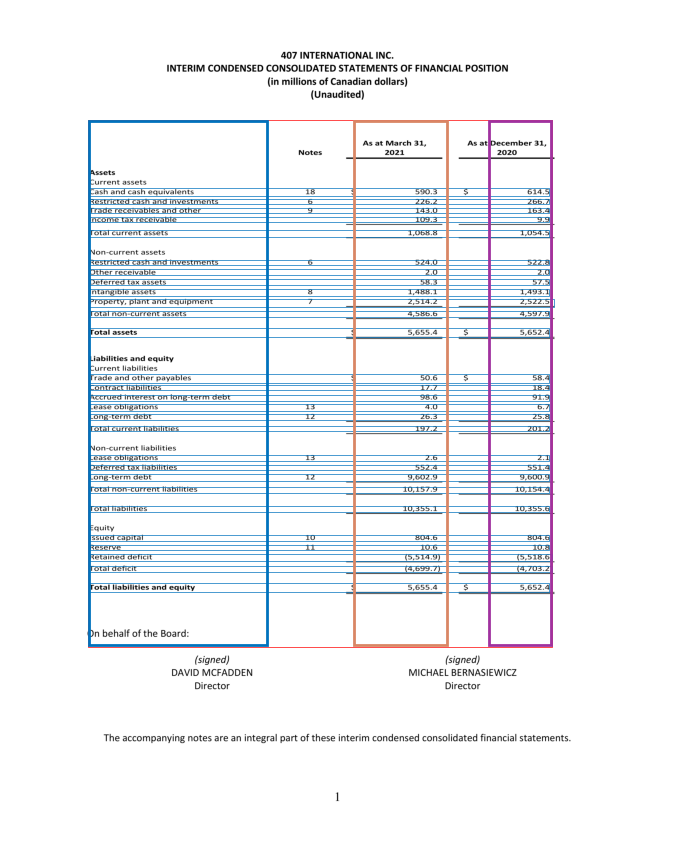

In [130]:
import fitz # This is actually PyMuPDF

# Specify financial statement filename
statement_filename, page_index = "../statements/407 International - March 31 2021.pdf", 1
# statement_filename, page_index = "../statements/Air Canada - December 31 2019.pdf", 6
# statement_filename, page_index = "../statements/BCE - Financial Report - 2020-2022.pdf", 82
# statement_filename, page_index = "../statements/Better Life Pharama Inc - Jan 31 Oct 31 2022.pdf", 2
# statement_filename, page_index = "../statements/NextGen Food Robotics Corp - 2022-04-30 - 2023-01-31..pdf", 2
# statement_filename, page_index = "../statements/Rogers - Q1-2020.pdf", 3
# statement_filename, page_index = "../statements/Starbucks - Annual Report - 2020.pdf", 53

# Convert PDF page to image
statement_pages = []
statement_doc = fitz.open(statement_filename)
statement_page = statement_doc[page_index].get_pixmap(dpi=250)

# Convert PDF page to image
page_pixmap = statement_page #s[page_index]
page_image = Image.frombytes("RGB", [page_pixmap.width, page_pixmap.height], page_pixmap.samples)

# Parse image dimensions
page_width = page_image.width
page_height = page_image.height
page_depth = 3

# Binarize image
binarized_array = global_adaptive_thresholding(page_image, page_height, page_width, page_depth)

# Display image
binarized_image = Image.fromarray(binarized_array).convert("RGB")

# Segment table
table_location = segment_table(binarized_image)

# Display image
# display_ratio = page_image.width / 500
# display_size = (int(page_image.width / display_ratio), int(page_image.height / display_ratio))
# display_image = page_image.resize(display_size)
# display(display_image)

# Process page image
validation_data = process_image(page_image)